In [ ]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

from time import time
import pandas as pd
import numpy as np

os.environ['OPENAI_KEY_SAE'] = os.environ['OAI_GENERAL']

current_dir = os.getcwd()
prefix = '../' if current_dir.endswith("experiments") else './'
df = pd.read_json(os.path.join(prefix, "demo-data", "yelp-demo-val-2K.json"), lines=True)

texts = df['text'].tolist()
labels = df['stars'].values

concepts = [
    "uses superlative language to describe the restaurant as the best in a specific category (e.g., 'best lobster roll', 'best bakery', 'best cheesesteaks')",
    "mentions experiences of food causing illness, such as food poisoning, stomach pain, or vomiting",
    "mentions long wait times for seating, food, or service",
    "complains about repeated service errors or unresolved issues despite multiple attempts to address them",
    "complains about poor or rude customer service",
]
texts_to_annotate = texts[:]
tasks = [(text, concept) for text in texts_to_annotate for concept in concepts]

df_annot = pd.DataFrame()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from hypothesaes.annotate import annotate
from hypothesaes.annotate import CACHE_DIR

start = time()
gt_model = 'gpt-4.1'
ground_truth = annotate(tasks, model=gt_model, n_workers=200, max_words_per_example=256, 
                        cache_path=os.path.join(CACHE_DIR, f'test_{gt_model}.json'))

y_gt = np.array([ground_truth[concept][text] for (text, concept) in tasks])
df_annot['ground_truth'] = y_gt

Found 500 cached items; annotating 0 uncached items


In [ ]:
MODELS = [
    "Qwen/Qwen3-0.6B",
    # "Qwen/Qwen3-4B",
    # "Qwen/Qwen3-8B",
    # "Qwen/Qwen3-14B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
    "HuggingFaceTB/SmolLM3-3B",
    "LiquidAI/LFM2-1.2B",
    # "mistralai/Mistral-7B-Instruct-v0.3",
]
TEMPERATURES = [0.0]
THINKING_OPTIONS = [True, False]
PROMPT_TEMPLATES = ["annotate-simple", "annotate"]

for model in MODELS:
    for temperature in TEMPERATURES:
        for thinking in THINKING_OPTIONS:
            for prompt_template in PROMPT_TEMPLATES:
                model_key = (model, temperature, thinking, prompt_template)

                cache_path = os.path.join(CACHE_DIR, f'test_{model}_temp={temperature}_think={thinking}_prompt={prompt_template}.json')
                max_tokens = 1000 if thinking else 10
                if not ('Qwen' in model or 'SmolLM3' in model) and thinking:
                    continue
                
                results = annotate(tasks, model=model, max_words_per_example=256, max_tokens=max_tokens, temperature=temperature, prompt_template_name=prompt_template,
                                   tokenizer_kwargs={'enable_thinking': thinking}, max_retries=0, cache_path=cache_path)
                df_annot[model_key] = np.array([results[concept][text] for (text, concept) in tasks])

In [ ]:
closed_models = ['gpt-4.1', 'gpt-4.1-mini', 'gpt-4.1-nano']
for model in closed_models:
    for prompt_template in ['annotate-simple', 'annotate']:
        model_key = (model, 0.0, False, prompt_template)
        if model_key in df_annot.columns:
            continue
        results = annotate(tasks, model=model, max_words_per_example=256, max_tokens=10, prompt_template_name=prompt_template, n_workers=100,
                           cache_path=os.path.join(CACHE_DIR, f'test_{model}_{prompt_template}.json'))
        df_annot[model_key] = np.array([results[concept][text] for (text, concept) in tasks])

In [13]:
from sklearn.metrics import f1_score, recall_score, precision_score
from scipy.stats import pearsonr
import pandas as pd

# Create results dataframe
results_data = []
y_true = df_annot['ground_truth'].values

for col in df_annot.columns:
    if col == 'ground_truth':
        continue
    
    y_pred = df_annot[col].values
    
    # Calculate metrics
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    correlation, _ = pearsonr(y_true, y_pred)
    
    # Extract components from tuple key
    if isinstance(col, tuple) and len(col) == 4:
        model_name, temperature, thinking, prompt = col
    else:
        # Fallback for non-tuple keys
        model_name = str(col)
        temperature = 0.0
        thinking = False
        prompt = 'unknown'
    
    results_data.append({
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'correlation': correlation,
        'model_name': model_name,
        'temperature': temperature,
        'prompt': prompt,
        'thinking': thinking
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('f1', ascending=False)
display(results_df.round(3))


,f1,recall,precision,correlation,model_name,temperature,prompt,thinking
6,0.964,0.952,0.976,0.961,gpt-4.1,0.0,annotate,False
5,0.909,0.952,0.870,0.901,gpt-4.1,0.0,annotate-simple,False
11,0.848,0.929,0.780,0.836,gpt-4o-mini,0.0,annotate-simple,False
8,0.826,0.905,0.760,0.812,gpt-4.1-mini,0.0,annotate,False
7,0.780,0.762,0.800,0.761,gpt-4.1-mini,0.0,annotate-simple,False
9,0.744,0.762,0.727,0.720,gpt-4.1-nano,0.0,annotate-simple,False
12,0.713,0.976,0.562,0.712,gpt-4o-mini,0.0,annotate,False
1,0.702,0.952,0.556,0.697,Qwen/Qwen3-8B,0.0,annotate-simple,False
0,0.690,0.952,0.541,0.686,Qwen/Qwen3-4B,0.0,annotate-simple,False
10,0.571,1.000,0.400,0.587,gpt-4.1-nano,0.0,annotate,False


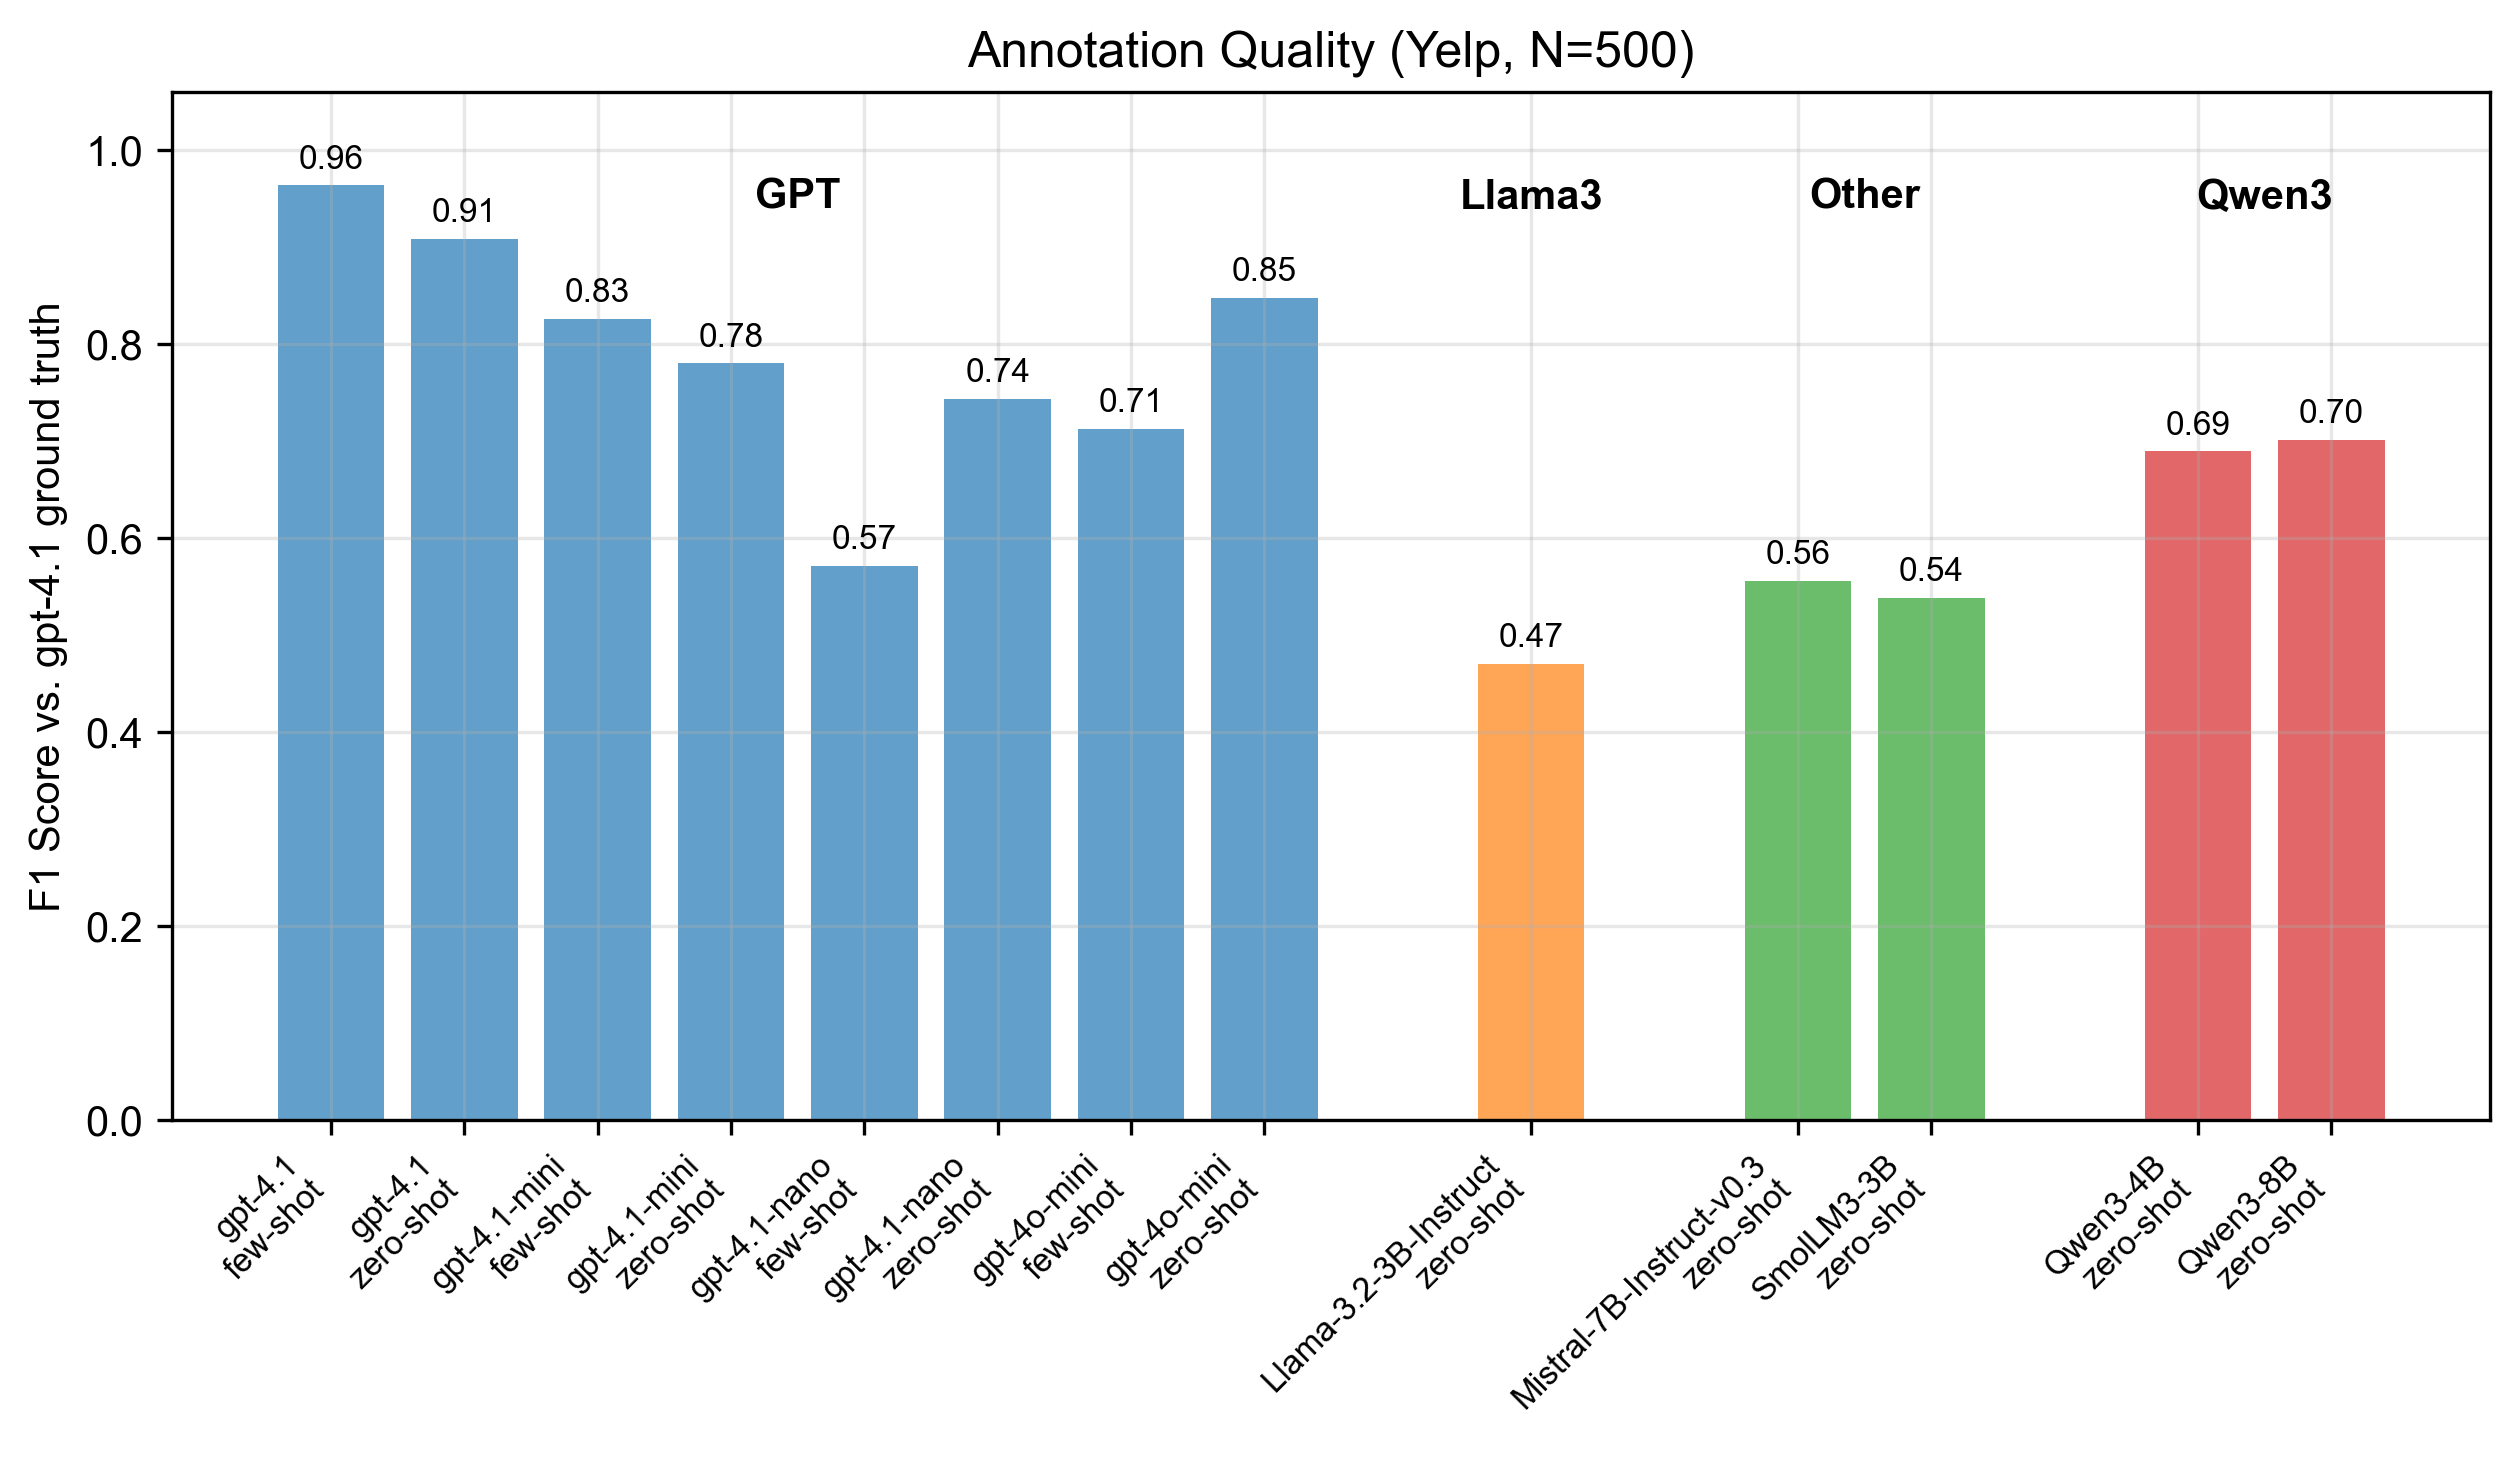

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def model_to_group(row):
    if 'gpt' in row['model_name'].lower():
        return 'GPT'
    # elif row['thinking']:
    #     return 'Reasoning'
    elif 'qwen' in row['model_name'].lower():
        return 'Qwen3'
    elif 'llama' in row['model_name'].lower():
        return 'Llama3'
    else:
        return 'Other'
    
def model_to_label(row, include_thinking=False):
    label_result = ''
    model_name = row['model_name']
    if '/' in model_name:
        model_name = model_name.split('/')[-1]
    label_result += f'{model_name}'
    prompt = row['prompt']
    if prompt == 'annotate-simple':
        label_result += f'\nzero-shot'
    elif prompt == 'annotate':
        label_result += f'\nfew-shot'
    if include_thinking:
        label_result += f'\nthinking={row["thinking"]}'
    return label_result

# Filter results for temperature=0.0 and exclude simple prompts
filtered_df = results_df[
    (results_df['temperature'] == 0.0) 
    # & (~results_df['prompt'].str.contains('simple', case=False, na=False))
].copy()

# Add display labels
include_thinking = filtered_df['thinking'].nunique() > 1
filtered_df['model_group'] = filtered_df.apply(model_to_group, axis=1)
filtered_df['prompt_label'] = filtered_df.apply(lambda row: model_to_label(row, include_thinking), axis=1)

# Group by model
model_groups = filtered_df.groupby('model_group')

# Create the plot
fig, ax = plt.subplots(figsize=(2 + len(filtered_df) * 0.5, 5), dpi=300)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

x_pos = 0
bar_width = 0.8
group_positions = []
all_f1_values = []
all_labels = []
group_centers = []
for i, (model_label, group_data) in enumerate(model_groups):
    color = colors[i % len(colors)]
    
    # Sort group data alphabetically by prompt_label
    group_data_sorted = group_data.sort_values('prompt_label')
    
    group_f1_scores = group_data_sorted['f1'].values
    group_positions.extend(range(x_pos, x_pos + len(group_data_sorted)))
    all_f1_values.extend(group_f1_scores)
    
    # Use prompt labels for x-axis
    prompt_labels = group_data_sorted['prompt_label'].values
    all_labels.extend(prompt_labels)
    
    # Calculate group center for group label
    group_center = x_pos + (len(group_data_sorted) - 1) / 2
    group_centers.append((group_center, model_label))
    
    # Plot vertical bars for this group with different opacity based on thinking
    for j, (idx, row) in enumerate(group_data_sorted.iterrows()):
        alpha = 0.4 if row['thinking'] else 0.7
        bar = ax.bar(x_pos + j, row['f1'], bar_width, color=color, alpha=alpha)
        
        # Add value labels on bars
        ax.text(bar[0].get_x() + bar[0].get_width()/2, bar[0].get_height() + 0.01,
                f'{row["f1"]:.2f}', ha='center', va='bottom', fontsize=8)
    
    x_pos += len(group_data_sorted) + 1  # Add space between groups

# Customize the plot
ax.set_ylabel('F1 Score vs. gpt-4.1 ground truth')
ax.set_title(f'Annotation Quality (Yelp, N={len(y_true)})')
ax.set_xticks(group_positions)
ax.set_xticklabels(all_labels, fontsize=8, rotation=45, ha='right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(all_f1_values) * 1.1)

# Add group labels below the x-axis
for center, group_label in group_centers:
    ax.text(center, 0.95 * max(all_f1_values), group_label, 
            ha='center', va='top', fontsize=10, fontweight='bold',
            transform=ax.get_xaxis_transform())

plt.tight_layout()
plt.show()


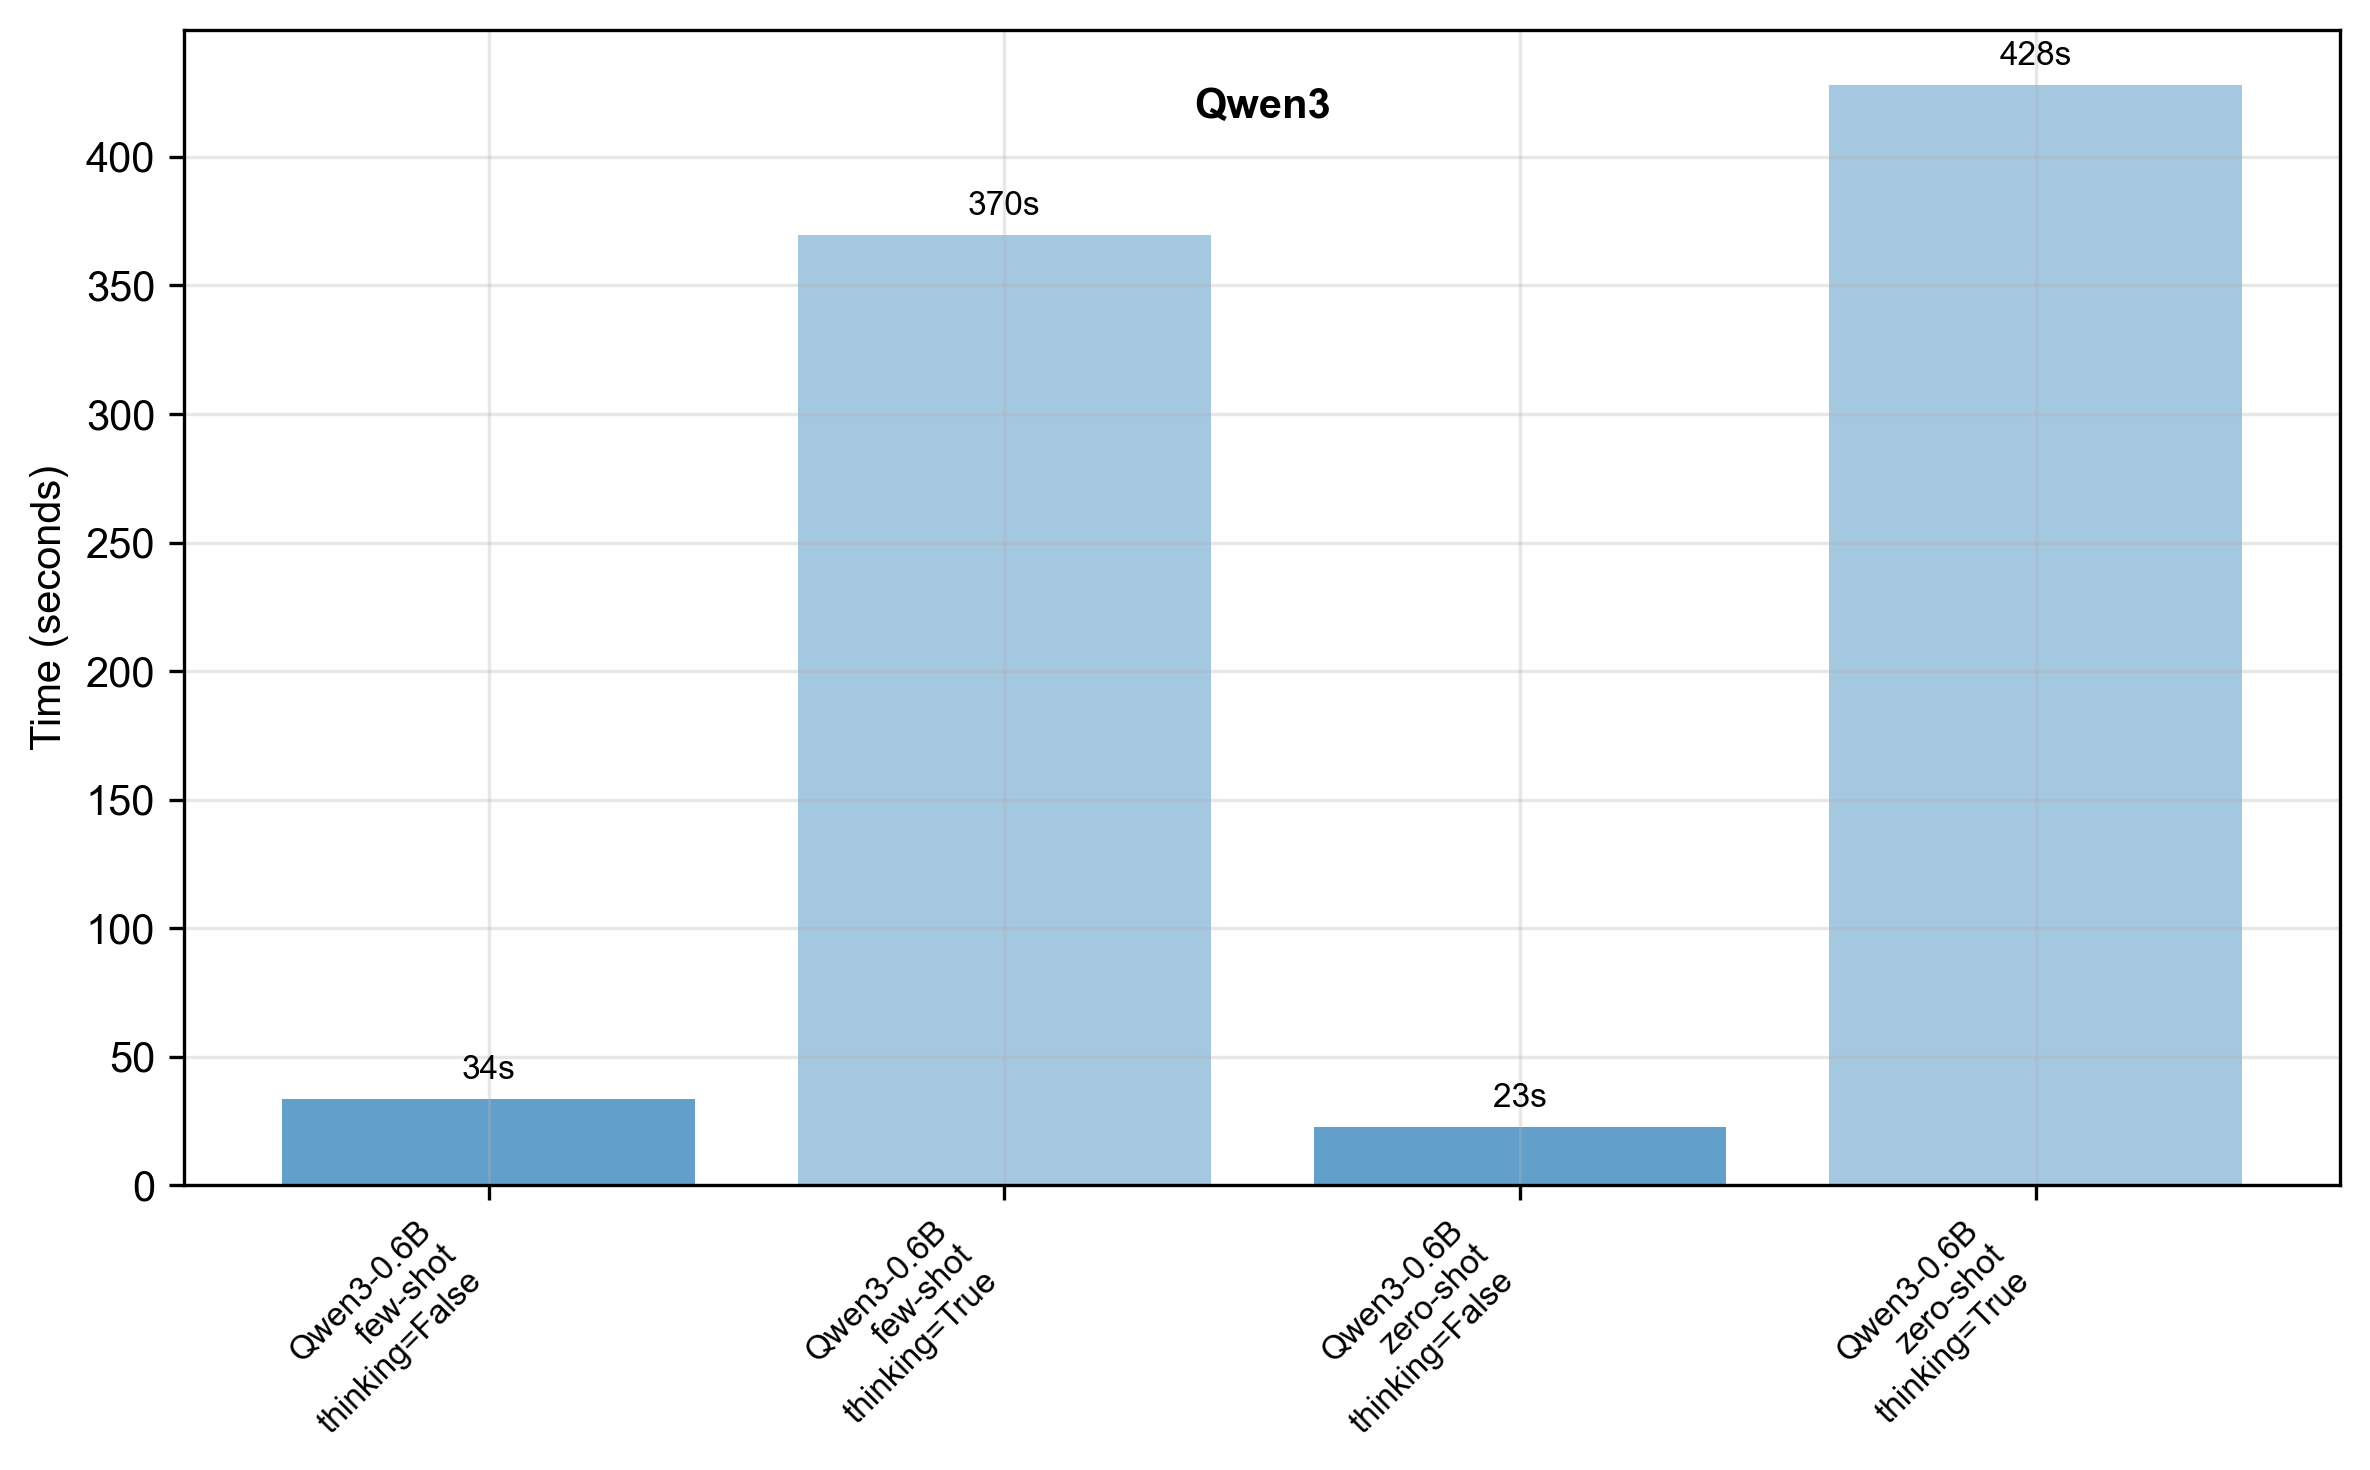

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

timing_data = """time (s)	model_name	temperature	prompt	thinking
427.9608106613159	Qwen/Qwen3-0.6B	0.0	annotate-simple	True
369.5815432071686	Qwen/Qwen3-0.6B	0.0	annotate	True
22.797560930252075	Qwen/Qwen3-0.6B	0.0	annotate-simple	False
33.794382095336914	Qwen/Qwen3-0.6B	0.0	annotate	False"""

df_timing = pd.read_csv(StringIO(timing_data), sep='\t')
df_timing['model_group'] = df_timing.apply(model_to_group, axis=1)
df_timing['prompt_label'] = df_timing.apply(lambda row: model_to_label(row, True), axis=1)

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

# Group by model
model_groups = df_timing.groupby('model_group')
x_pos = 0
group_centers = []

for i, (model_label, group_data) in enumerate(model_groups):
    group_data_sorted = group_data.sort_values('prompt_label')
    
    # Calculate group center
    group_center = x_pos + (len(group_data_sorted) - 1) / 2
    group_centers.append((group_center, model_label))
    
    # Plot bars with opacity based on thinking
    for j, (idx, row) in enumerate(group_data_sorted.iterrows()):
        alpha = 0.4 if row['thinking'] else 0.7
        bar = ax.bar(x_pos + j, row['time (s)'], 0.8, color='#1f77b4', alpha=alpha)
        ax.text(bar[0].get_x() + bar[0].get_width()/2, bar[0].get_height() + 5,
                f'{row["time (s)"]:.0f}s', ha='center', va='bottom', fontsize=8)
    
    x_pos += len(group_data_sorted) + 1

ax.set_ylabel('Time (seconds)')
ax.set_xticks(range(len(df_timing)))
ax.set_xticklabels(df_timing.sort_values('prompt_label')['prompt_label'], 
                   fontsize=8, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Add group labels
for center, group_label in group_centers:
    ax.text(center, ax.get_ylim()[1] * 0.95, group_label, 
            ha='center', va='top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
